In [6]:
import cmdstanpy
import pandas as pd
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats
import patsy
from collections import defaultdict

MODEL_PATH = 'time_model_2.stan'

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [7]:
temps = pd.read_csv('data/Hyperlocal_Temperature_Monitoring.csv')
temps.head()

,Sensor.ID,AirTemp,Day,Hour,Latitude,Longitude,Year,Install.Type,Borough,ntacode
0,Bk-BR_01,71.189000,06/15/2018,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
1,Bk-BR_01,70.243333,06/15/2018,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
2,Bk-BR_01,69.392667,06/15/2018,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
3,Bk-BR_01,68.263167,06/15/2018,4,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
4,Bk-BR_01,67.114000,06/15/2018,5,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81


In [8]:
covariates = pd.read_csv('data/temp3.csv').round(8)
covariates2 = pd.read_csv('data/temp_1.csv').round(8)
covariates = covariates.merge(covariates2)
covariates['mean_fa_ratio'] = covariates['mean_fa_ratio'].fillna(0)
temps = temps.drop(index=np.where(temps['AirTemp'].isna())[0])
data = temps.merge(covariates, how='outer', on=['Latitude','Longitude'])

In [9]:
data['Day'] =pd.to_datetime(data.Day)
data = data.sort_values(by=['Sensor.ID','Day'])

In [275]:
data = data[data.Day.dt.month.isin([7,8])].reset_index(0).drop(columns='index')

In [439]:
g = data.groupby(['Sensor.ID'])

H = 24
K = 4
N = len(g.indices)
W = 7

y = []#np.zeros([N,H])
X = []#np.zeros([N,K])
i = 0
for k,_ in tqdm(g.indices.items()):
    sub_group = g.get_group(k)
    unique_dates = sub_group.Day.unique()
    windows = [unique_dates[x:x+W] for x in range(0, len(unique_dates), W)]
    for window in windows:
        hours = defaultdict(list)
        for day in window:
            day_group = sub_group[sub_group.Day == day]
            for _,row in day_group.iterrows():
                hours[row.Hour].append(row.AirTemp)
        result = np.zeros(H)
        for k,v in hours.items():
            result[k] = np.mean(v)
        y.append(result)
        # Add back mean floor area ratio
        covariates = list(sub_group[['num_build500','min_distance_park','num_trees_15m']].iloc[0].values)+[1] 
        X.append(covariates)

y = np.array(y)
X = np.array(X)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 423/423 [02:01<00:00,  3.47it/s]


In [440]:
from sklearn.preprocessing import StandardScaler

In [441]:
n = StandardScaler()
X_t = n.fit_transform(X)

In [442]:
X_t

array([[ 1.3773592 , -0.71237651,  0.31510679,  0.        ],
       [ 1.3773592 , -0.71237651,  0.31510679,  0.        ],
       [ 1.3773592 , -0.71237651,  0.31510679,  0.        ],
       ...,
       [-0.73722897,  2.08854384,  0.31510679,  0.        ],
       [-0.73722897,  2.08854384,  0.31510679,  0.        ],
       [-0.73722897,  2.08854384,  0.31510679,  0.        ]])

In [479]:
N = y.shape[0]
X_new_size = 20
K = X.shape[1]
# X_size = N - X_new_size
X_size = 50
shuff_idx = random.shuffle(list(range(N)))
shuff_y, shuff_X = y[shuff_idx,:][0], X[shuff_idx,:][0]
beta_mean = np.random.normal(size=X.shape[1])
beta_sd = np.ones(X.shape[1]) #np.random.uniform(size=X.shape[1])

In [480]:
d = {'N': N, 'M': X_size, 'H': H, 'K': K, 'X': shuff_X, 'y': shuff_y,'beta_mean': beta_mean,'beta_sd': beta_sd,'y_cov':shuff_y[:X_size,:].T}

In [393]:
model = CmdStanModel(stan_file=MODEL_PATH)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/sotiriskaragounis/git/UHInyc/time_model_2


In [481]:
import time

In [482]:
t1 = time.time()
bern_vb = model.sample(data=d)
t2 = time.time()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [483]:
t2 - t1

174.53240823745728

## MCMC

In [484]:
y_sims = bern_vb.stan_variable(var='y_rep')
b = bern_vb.stan_variable(var='beta')
x_sims = [i for _ in range(4000) for i in range(24)]

<AxesSubplot:xlabel='variable', ylabel='value'>

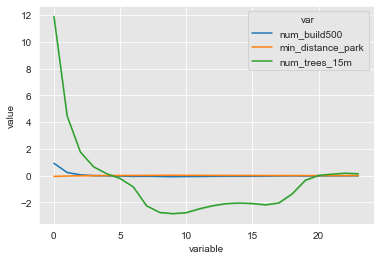

In [485]:
cols = ['num_build500','min_distance_park','num_trees_15m']
i2v = {i:v for i,v in enumerate(cols)} 

df2 = pd.DataFrame()
for i in range(len(cols)):
    temp = pd.DataFrame(b[:,:,i])
    temp['var'] = i2v[i]
    df2 = df2.append(temp)
    
df2 = pd.melt(df2,id_vars=['var'], value_vars=list(range(24)))
sns.lineplot(data=df2,x='variable',y='value',hue='var')

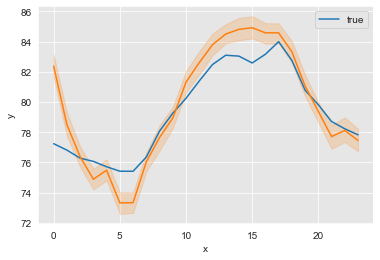

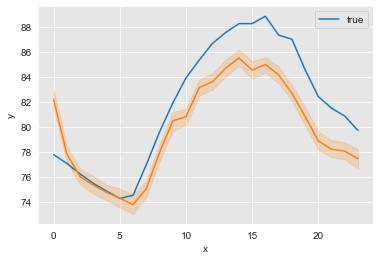

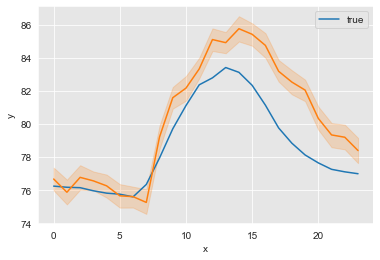

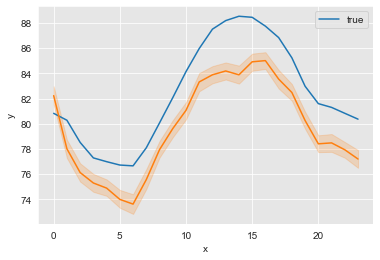

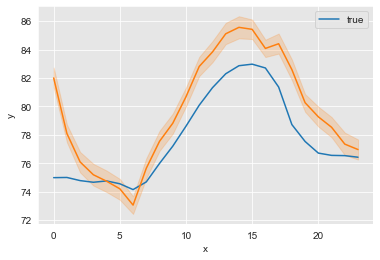

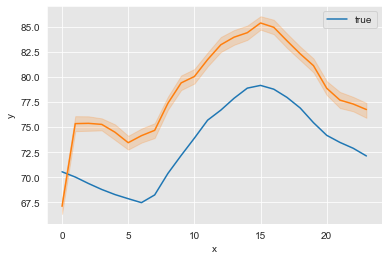

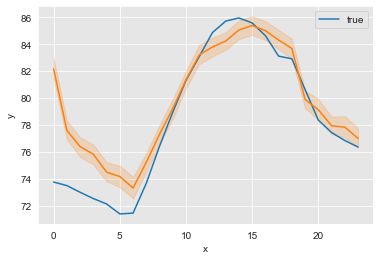

In [489]:
s = 100
r = random.sample(list(range(50)),7)
for j in r:
    sns.lineplot(x=range(24),y=shuff_y[j,:],label='true')
    idx = random.sample(list(range(y_sims.shape[0])),s)
    df = pd.DataFrame()
    df['y'] = y_sims[idx,j,:].reshape(-1)
    df['x'] = [i for _ in range(s) for i in range(24)]
    sns.lineplot(data=df,x='x',y='y')
    plt.show()

In [487]:
np.min(y,axis=0)

array([67.30943333, 66.2236    , 65.5331    , 65.4188    , 65.00056667,
       64.5233    , 64.49013333, 67.36856667, 68.86986111, 70.31219445,
       71.53047222, 73.05363889, 74.41869048, 75.55194444, 76.06527778,
       76.28933333, 76.30666667, 75.79902381, 74.91778571, 73.98938095,
       72.49642857, 70.12678571, 69.27266667, 68.76959524])

In [488]:
np.max(y,axis=0)

array([ 84.03969048,  83.4892619 ,  82.48714286,  82.22028572,
        81.79119048,  81.50311905,  81.98940476,  86.3802619 ,
        91.77602381,  95.47561905,  97.33466665,  98.82695238,
        99.75660119, 101.28966665, 101.91115648, 103.04218452,
       102.24723809, 101.04733332,  95.76897619,  90.91002381,
        88.21595238,  86.01188095,  85.03452778,  84.22978572])

In [139]:
np.max(y_sims[:,0,:],axis=0).shape

(24,)